# Example with the dummy data


The first thing we need to do is import some essential stuff. Theses also have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Now to the fun stuff, we import our module!

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
%load_ext autoreload
%autoreload 2

## Dummy data retrieval

The next thing we want to do is generate a dummy dataset. The dataset is generated by a changepoint each weekend. This are given back as parameter aswell and can be added to the model.

INFO     [covid19_inference.dummy_data] Initial infected 4


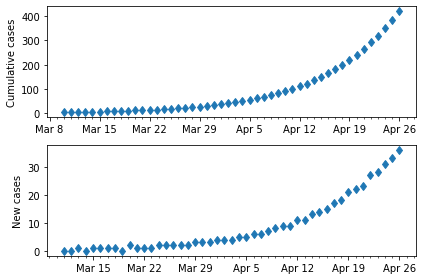

In [171]:
#Create dates for filter/data generation
data_begin = datetime.datetime(2020,3,10)
data_end = datetime.datetime(2020,4,26)

#Get dummy data
total_cases, changepoints = cov19.dummy_data.get_dummy_data(data_begin, data_end, 0.5)
new_cases_obs = total_cases.diff().iloc[1:]

#Plot dummy data
fig, ax = plt.subplots(2,1)
cov19.plot._timeseries(total_cases["confirmed"].index, total_cases["confirmed"],ax[0],lw=0)
cov19.plot._timeseries(new_cases_obs["confirmed"].index, new_cases_obs["confirmed"],ax[1],lw=0)
ax[0].set_ylabel("Cumulative cases")
ax[1].set_ylabel("New cases")
cov19.plot._format_date_xticks(ax[0])
cov19.plot._format_date_xticks(ax[1])
plt.tight_layout()


In [172]:
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

#Get priors for changepoints from dummy data
change_points = []
for cp in changepoints:
    change_points.append(dict(pr_mean_date_transient = cp[0],
         pr_sigma_date_transient = 6,
         pr_median_lambda = cp[1],
         pr_sigma_lambda = 2))

Then, create the model:

In [173]:
params_model = dict(new_cases_obs = new_cases_obs["confirmed"],
                    data_begin = data_begin,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len

## MCMC sampling

In [176]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 213.52:  18%|█▊        | 35399/200000 [01:02<04:50, 567.30it/s]
Convergence achieved at 35400
INFO     [pymc3.variational.inference] Convergence achieved at 35400
Interrupted at 35,399 [17%]: Average Loss = 235.21
INFO     [pymc3.variational.inference] Interrupted at 35,399 [17%]: Average Loss = 235.21
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_7_log, transient_len_6_log, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_7, transient_day_6, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_7_log, lambda_6_log, lambda_5_log, lambda_

## Plotting

Plotting tools are rudimentary right now. But one can always write custom plotting function 
by accessing the samples stored in the trace.

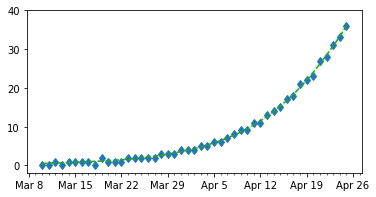

In [179]:
x = pd.date_range(data_begin,data_end-datetime.timedelta(days=1))
ax = cov19.plot._timeseries(x,
                            new_cases_obs["confirmed"],
                            what="data",
                            draw_ci_95=False,
                            lw=0)

# Plot the model
y = trace["new_cases"][:,:model.data_len]
x = pd.date_range(model.data_begin,model.data_end)
ax = cov19.plot._timeseries(x,y,ax,what="fcast", draw_ci_95=True)
cov19.plot._format_date_xticks(ax)


We can also compare our changepoints from the dummy data with the changepoints from the trace.

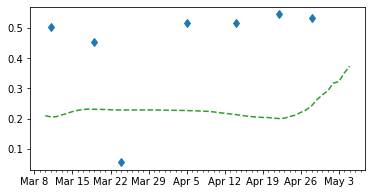

In [197]:
#First the observed changepoints
ax = cov19.plot._timeseries(np.array(changepoints)[:,0],
                            np.array(changepoints)[:,1],
                            what="data",
                            draw_ci_95=False,
                            lw=0)
#Changepoints from trace
x = pd.date_range(model.data_begin,model.sim_end)
y = trace["lambda_t"][:,(model.data_begin-model.sim_begin).days:model.sim_len]

cov19.plot._timeseries(x,y,ax,what="fcast", draw_ci_95=False)
cov19.plot._format_date_xticks(ax)

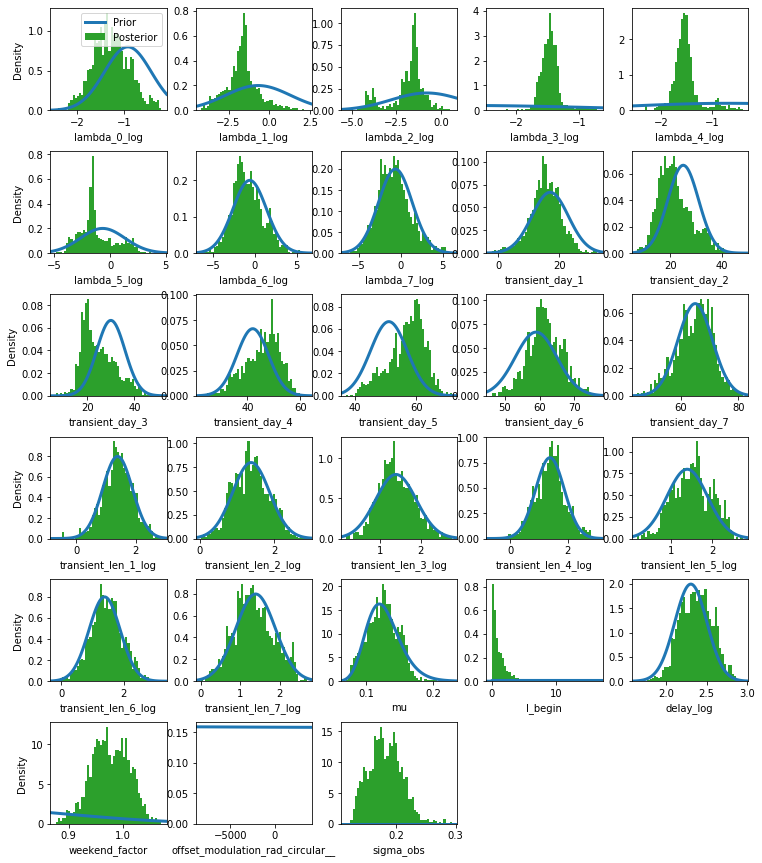

In [198]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
